# 5. Quanvolutional Neural Networks

Install pre-requisites required for this notebook to run

**Note:** This step is optional if you are running this notebook from the docker container

In [10]:
using Pkg;

Pkg.add("PyCall");
Pkg.add("AWS");

Pkg.add("Flux");
Pkg.add("MLDatasets");

Pkg.add("Plots");
Pkg.add("PyPlot");
Pkg.add("Colors");
Pkg.add("ProgressMeter");

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Chan

Import all required libraries

In [11]:
using Base: @kwdef
using Colors
using Plots
using ProgressMeter;

using Flux;
using Flux: onehotbatch, onecold, onehot, @epochs;
using Flux.Data: DataLoader
using Flux.Losses: logitcrossentropy

using MLDatasets

using PyCall
using AWS: @service
@service S3;
@service Braket;
@service STS;

# Braket imports
awsbraket = pyimport("braket.aws");
devices   = pyimport("braket.devices");
circuit   = pyimport("braket.circuits");

We are going to use the LocalSimulator to run this notebook, so that we don't incur any cost.

In [12]:
qpu = devices.LocalSimulator();

## The Dataset

We will use the FashionMNIST dataset to demonstrate Quanvolutional Neural Networks. [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist) is a dataset of images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Fashion-MNIST is intended to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

Each training and test example is assigned to one of the following labels:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

In [34]:
TRAIN_SIZE = 10; #60000;
TEST_SIZE = 10 #10000;
BATCH_SIZE = 1;
SHUFFLE = true;
LABELS = ["T-Shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"];
NUM_CLASSES = 10;
IMAGE_SIZE = (28,28,1);
DEVICE = cpu;
PRE_PROCESS = true;
EPOCHS=1;
Q_LAYERS = 1;
CONV_SIZE = 4;

In [31]:
xtrain, ytrain = MLDatasets.FashionMNIST.traindata(Float32);
xtest, ytest = MLDatasets.FashionMNIST.testdata(Float32);

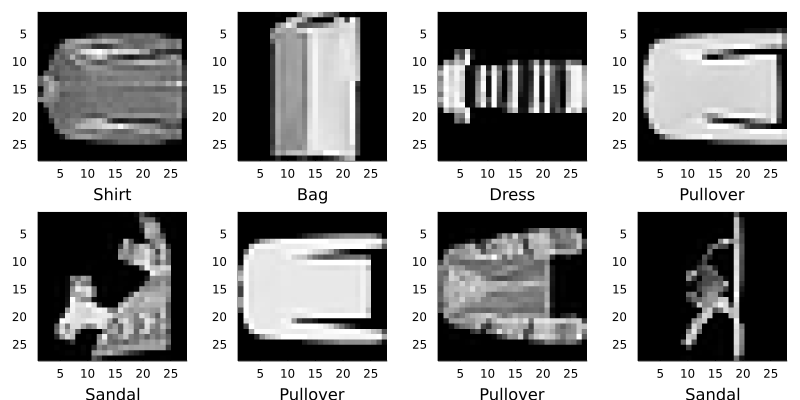

In [32]:
x = []
for i in 1:8
    idx = rand(1:60000)
    image = xtrain[:,:,idx]
    label = ytrain[idx]
    push!(x,plot(Gray.(image), size=(100, 100), xlabel=LABELS[label + 1]))
end

plot(x..., layout=(2,4), size = (800,400))

## Variational Circuits as Feature Extractors

Similar to how CNNs are used as a feature extractor in classical deep learning, we can use variational quantum circuits in place of the Convolutional filters. 

![](assets/qnncircuit.png)


In [19]:
rand_params = rand(-pi:pi, 4)
function random_layer(target_circuit)
    target_circuit.add(circuit.Circuit().rx(0, rand_params[1]))
    target_circuit.add(circuit.Circuit().rz(3, rand_params[2]))
    target_circuit.add(circuit.Circuit().cnot(2,1))
    target_circuit.add(circuit.Circuit().cnot(3,0))
    target_circuit.add(circuit.Circuit().ry(0,rand_params[3]))
    target_circuit.add(circuit.Circuit().rx(0,rand_params[4]))
    
    return target_circuit
end;

In [27]:
function get_filter(phi)
    conv_filter = circuit.Circuit()
    
    for wire in 1:CONV_SIZE
        conv_filter.add(circuit.Circuit().ry(wire - 1, pi * phi[wire]))
    end

    conv_filter = random_layer(conv_filter)
    
    conv_filter.expectation(observable=circuit.Observable.Z())
    
    return conv_filter 
end;

In [35]:
println(get_filter([1,2,3,4]).diagram())

T  : |   0    |    1     |2|   3    |    4    | Result Types |
                                                              
q0 : -Ry(3.14)-Rx(-0.142)-X-Ry(2.86)-Rx(-2.14)-Expectation(Z)-
                          |                    |              
q1 : -Ry(6.28)-X----------|--------------------Expectation(Z)-
               |          |                    |              
q2 : -Ry(9.42)-C----------|--------------------Expectation(Z)-
                          |                    |              
q3 : -Ry(12.6)-Rz(-0.142)-C--------------------Expectation(Z)-

T  : |   0    |    1     |2|   3    |    4    | Result Types |


In [45]:
function quanv(image)
    out = zeros(14, 14, 4)
    for j = range(1, 28, step=2)
        conv_filter = nothing
        for k = range(1, 28, step=2)
            conv_filter = get_filter([
                    image[j, k],
                    image[j, k + 1],
                    image[j + 1, k],
                    image[j + 1, k + 1]
            ])
            qonv = qpu.run(conv_filter, shots=0).result().result_types[1].value
            for c in 1:4
                out[ceil(Int32, j/2), ceil(Int32, k/2), c] = qonv[c]
            end
        end
    end
    
    return out
end;

In [46]:
qxtrain = zeros(14, 14, 4, TRAIN_SIZE)
qxtest = zeros(14, 14, 4, TEST_SIZE)

plots = []

for i in 1:TRAIN_SIZE
    qxtrain[:,:,:, i] = quanv(xtrain[:,:,i])
end

for i in 1:TEST_SIZE
    qxtest[:,:,:, i] = quanv(xtest[:,:,i])
end

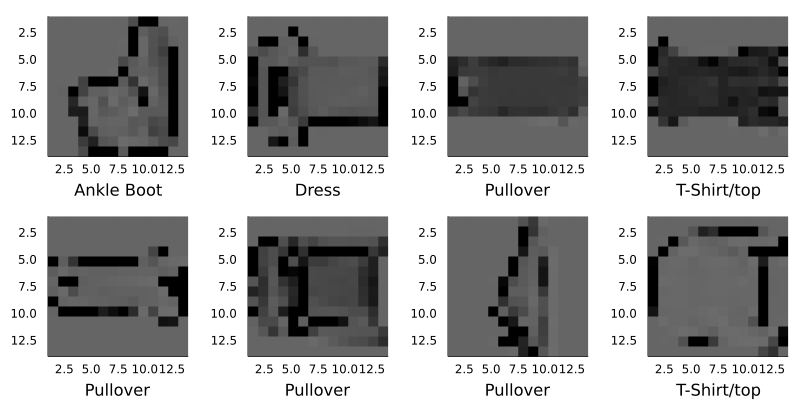

In [47]:
x = []
for i in 1:8
    idx = rand(1:TRAIN_SIZE)
    image = qxtrain[:,:,1,i]
    label = ytrain[idx]
    push!(x,plot(Gray.(image), size=(100, 100), xlabel=LABELS[label + 1]))
end

plot(x...,  layout=(2,4), size = (800,400))

In [52]:
train_loader = DataLoader((qxtrain[:, :, :, 1:TRAIN_SIZE], ytrain[1:TRAIN_SIZE]), batchsize=1, shuffle=true);
test_loader = DataLoader((qxtest[:, :, :, 1:TEST_SIZE], ytest[1:TEST_SIZE]), batchsize=1, shuffle=true);

## Model Training

In [53]:
function loss_and_accuracy(data_loader, model, device)
           acc = 0
           ls = 0.0f0
           num = 0
           for (x, y) in data_loader
               x, y = device(x), device(y)
               ŷ = model(x)
               ls += logitcrossentropy(model(x), y, agg=sum)
               acc += sum(onecold(cpu(model(x))) .== onecold(cpu(y)))
               num +=  size(x, 2)
           end
           return ls / num, acc / num
end;

In [54]:
function build_model(; imgsize=IMAGE_SIZE, nclasses=NUM_CLASSES)
    return Chain(
        Flux.flatten,
        Dense(prod(IMAGE_SIZE), 32, relu),
        Dense(32, nclasses)
    )
end;
model = build_model() |> DEVICE;

In [55]:
function optimize(; model, train_loader, test_loader, epochs=EPOCHS, device=DEVICE)
    opt = ADAM(3e-4);
    ps = Flux.params(model);
    for epoch in 1:epochs
        for (x, y) in train_loader
            x, y = device(x), device(y) # transfer data to device
            gs = gradient(() -> logitcrossentropy(model(x), y), ps) # compute gradient
            Flux.Optimise.update!(opt, ps, gs) # update parameters
        end
        train_loss, train_acc = loss_and_accuracy(train_loader, model, device);
        test_loss, test_acc = loss_and_accuracy(test_loader, model, device);
        println("Epoch=$epoch")
        println("  train_loss = $train_loss, train_accuracy = $train_acc")
        println("  test_loss = $test_loss, test_accuracy = $test_acc")
    end
end;

In [56]:
optimize(model=model, train_loader=train_loader, test_loader=test_loader)

Epoch=1
  train_loss = 5.76447110212075, train_accuracy = 0.0
  test_loss = 7.536996020820856, test_accuracy = 0.0
